# Assginment #2
• Repeat the experiment from page #64-#67 using the full dataset  <br>
• Without limiting it to just 1000 rows.

In [1]:
import string
import timeit

import numpy as np
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import pandas as pd
from ordered_set import OrderedSet
import re

In [2]:
def get_and_clean_data():
    data = pd.read_csv('./resource/software_developer_united_states_1971_20191023_1.csv')
    description = data['job_description']
    cleaned_description = description.apply(lambda s: s.translate(str.maketrans('', '', string.punctuation + u'\xa0')))
    cleaned_description = cleaned_description.apply(lambda s: s.lower())
    cleaned_description = cleaned_description.apply(lambda s: s.translate(str.maketrans(string.whitespace, ' '*len(string.whitespace), '')))
    cleaned_description = cleaned_description.drop_duplicates()
    return cleaned_description

In [3]:
def m2_elapsed_set():
    cleaned_description = get_and_clean_data()

    cleaned_description = cleaned_description.apply(lambda s: re.sub(r'[^A-Za-z]', ' ', s))
    cleaned_description = cleaned_description.apply(lambda s: re.sub(r'\s+',' ', s))

    tokenized_description = cleaned_description.apply(lambda s: word_tokenize(s))

    stop_dict = set(stopwords.words())
    sw_removed_description = tokenized_description.apply(lambda s: list(OrderedSet(s) - stop_dict))
    sw_removed_description = sw_removed_description.apply(lambda s: [word for word in s if len(word)>2])

    concated = np.unique(np.concatenate([s for s in tokenized_description.values]))
    stem_cache = {}
    ps = PorterStemmer()
    for s in concated: 
        stem_cache[s] = ps.stem(s)
    stemmed_description = sw_removed_description.apply(lambda s: [stem_cache[w] for w in s])
    return stemmed_description

In [4]:
from sklearn.feature_extraction.text import CountVectorizer


In [5]:
stemmed_description = m2_elapsed_set()

In [6]:
arry_exp = {}
dok_exp = {}
lil_exp = {}
coo_exp = {}
csc_exp = {}



for w in range(1000, 10001, 1000): 
    print(w)
    cv = CountVectorizer(analyzer=lambda x: x)
    X = cv.fit_transform(stemmed_description[:w])
    XX = X.toarray()
    arry_exp[w] = timeit.timeit(lambda: np.matmul(XX, XX.T), number=1)
    dok_exp[w] = timeit.timeit(lambda: X.todok()*X.T.todok(), number=1)
    lil_exp[w] = timeit.timeit(lambda: X.tolil()*X.T.tolil(), number=1)
    coo_exp[w] = timeit.timeit(lambda: X.tocoo()*X.T.tocoo(), number=1)
    csc_exp[w] = timeit.timeit(lambda: X.tocsc()*X.T.tocsc(), number=1)
        


1000
2000
3000
4000
5000
6000
7000
8000
9000
10000


In [7]:
compare = pd.concat([pd.DataFrame.from_dict(arry_exp, orient='index', columns=['array_exp']), pd.DataFrame.from_dict(dok_exp, orient='index', columns=['dok_exp']), pd.DataFrame.from_dict(lil_exp, orient='index', columns=['lil_exp']), pd.DataFrame.from_dict(coo_exp, orient='index', columns=['coo_exp']), pd.DataFrame.from_dict(csc_exp, orient='index', columns=['csc_exp'])] ,axis=1)
compare

,array_exp,dok_exp,lil_exp,coo_exp,csc_exp
1000,5.286209,0.206062,0.081089,0.059164,0.057581
2000,30.638549,0.573394,0.288657,0.246748,0.239478
3000,85.596504,1.079400,0.636508,0.561662,0.535475
4000,175.401061,1.694030,1.044700,0.956528,0.954347
5000,311.670032,2.640063,1.590727,1.509943,1.511832
6000,492.918652,3.422096,2.330008,2.218298,2.205929
7000,772.909193,4.589110,3.238062,3.085741,3.040339
8000,945.577918,5.149769,3.814780,3.619312,3.625334
9000,943.529969,5.582280,3.777900,3.655956,3.694479
10000,947.810622,5.180773,3.760832,3.666300,3.636745


Text(0, 0.5, 'elapsed time (s)')

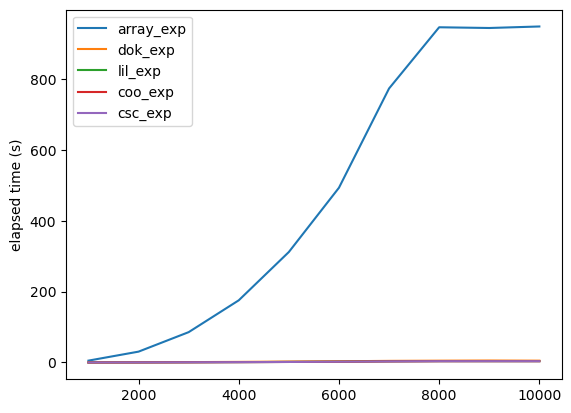

In [8]:
p = compare.plot()
p.set_ylabel('elapsed time (s)')